# Libraries

In [4]:
source("tools.R")

## Prior likelihoods

In [21]:
data_prior <- read_csv("data/for_composititional_analysis_prior.csv")

dict_prior <- data_prior %>% 
                        group_by(id, pid, scenario) %>%
                        summarize()

Warning message:
"Missing column names filled in: 'X1' [1]"Parsed with column specification:
cols(
  X1 = col_integer(),
  id = col_integer(),
  pid = col_character(),
  scenario = col_character(),
  x = col_integer(),
  y = col_double()
)


In [22]:
lmls_prior <- read_csv("output/lmls_prior.csv")

Warning message:
"Missing column names filled in: 'X1' [1]"Parsed with column specification:
cols(
  X1 = col_integer(),
  l = col_double(),
  `l*p` = col_double(),
  `l*p+r` = col_double(),
  `l*r` = col_double(),
  `l*r*p` = col_double(),
  `l*r+p` = col_double(),
  `l+p` = col_double(),
  `l+r` = col_double(),
  `l+r*p` = col_double(),
  `l+r+p` = col_double(),
  p = col_double(),
  `p*r` = col_double(),
  `p+r` = col_double(),
  r = col_double()
)


In [23]:
lmls_prior %>% head

X1,l,l*p,l*p+r,l*r,l*r*p,l*r+p,l+p,l+r,l+r*p,l+r+p,p,p*r,p+r,r
1,-713.6954,-8.438396e-02,-146.6802,-851.89829,-851.89688,-322.6189,791.0454,821.78723,927.2291,-323.47298,-323.0216,804.48813,-548.3215,792.3592
10,-1097.0542,-1.097054e+03,-10196.9489,-68.44092,-2035.82151,141.9539,148.8720,148.07899,-10196.9489,1468.08628,1537.9242,-51685.97435,1516.7239,1540.7145
100,-1196.2895,-1.196289e+03,60.4096,-94.76571,-98.14110,815.7817,-245.2160,899.05122,818.8646,65.02978,-761.1522,69.69232,994.7514,855.1832
101,-884.5586,-8.845586e+02,-2511.4764,-21.25770,-21.48428,-369.3005,-437.5120,90.20008,1129.5959,98.89978,-905.7997,1191.32516,1159.0688,1128.8089
102,-1428.1828,-2.631303e+02,-132.9282,-266.09369,-60.38163,-996.5167,-1428.1828,82.70370,169.0308,-831.25674,-1717.5405,-581.34877,-169.7323,-39.2825
103,-1055.6152,-1.055620e+03,-7682.7321,-57.30613,-2035.23194,1579.0880,150.1733,150.17337,-7682.7321,149.92483,-182.1528,-33875.75641,-175.4362,1616.2660


In [19]:
exp(c(1,2,3,4))

[1]  2.718282  7.389056 20.085537 54.598150

In [24]:
kernels <- c("l", "p", "r", "l+p", "l+r", "p+r", "l*r", "l*p", "p*r", "l+r+p", "l+r*p", "l*r+p", "l*p+r", "l*r*p")

lmls_prior<- lmls_prior %>% 
                gather(kernel, lml, kernels)

colnames(lmls_prior) = c('id', 'kernel', 'lml')

lmls_prior <- merge(x = lmls_prior, y = dict_prior, by = c("id", "id"), all.x = TRUE)

In [25]:
lmls_prior$probability <- exp(lmls_prior$lml)

lmls_prior %>% head

id,kernel,lml,pid,scenario,probability
1,l,-713.6954,a001,Temperature,1.111840e-310
1,l*r+p,-322.6189,a001,Temperature,7.733593e-141
1,l+r*p,927.2291,a001,Temperature,Inf
1,l*r*p,-851.8969,a001,Temperature,0.000000e+00
1,p*r,804.4881,a001,Temperature,Inf
1,l+r+p,-323.4730,a001,Temperature,3.292075e-141


In [10]:
to_plot<- lmls_prior %>% 
            group_by(pid, scenario) %>%
            mutate(lml_mean = mean(lml),
                   lml_sd = sd(lml),
                   lml_norm = (lml - lml_mean)/lml_sd) %>%
            group_by(kernel, scenario) %>%
            summarize(value = mean(lml_norm),
                      lo_ci = t.test(lml_norm, conf.level=0.95)$conf.int[1],
                      hi_ci = t.test(lml_norm, conf.level=0.95)$conf.int[2])

Warning message:
"package 'bindrcpp' was built under R version 3.3.3"

In [11]:
to_plot$kernel <- factor(to_plot$kernel, levels=kernels)

In [12]:
lmls_temperature <- to_plot %>% filter(scenario == "Temperature")
lmls_rain <- to_plot %>% filter(scenario == "Rain")
lmls_sales <- to_plot %>% filter(scenario == "Sales")
lmls_gym <- to_plot %>% filter(scenario == "Gym members")
lmls_salary <- to_plot %>% filter(scenario == "Salary")
lmls_fb <- to_plot %>% filter(scenario == "FB Friends")

In [13]:
plot_lmls <- function(prop_data, title, hide_x=FALSE, hide_y=FALSE) {
    plot <- prop_data %>%
                ggplot(aes(x=kernel, y=value)) + 
                    geom_bar(stat="identity") +
                    #ylim(0, 0.5) +
                    coord_cartesian (ylim=c(-1.2,1.0)) +
                    labs(title = title) +
                    ggthemes::theme_few() +
                    xlab("Kernel composition") + ylab("Mean Standardized\nLog Likelihood") +
                    geom_errorbar(aes(ymin=as.numeric(lo_ci), ymax=as.numeric(hi_ci)),
                                      width=.3,                   
                                      position=position_dodge(.9)) +
                    theme(axis.text.x = element_text(angle = 90,  vjust = 0.5, hjust=0),
                          text = element_text(size=12, family="serif"),
                          plot.title = element_text(hjust = 0.5))
    
    if(hide_x){
        plot <- plot + theme(axis.title.x=element_blank())
    }
    if(hide_y){
        plot <- plot + theme(axis.title.y=element_blank())
    }
    
    return(plot)
}

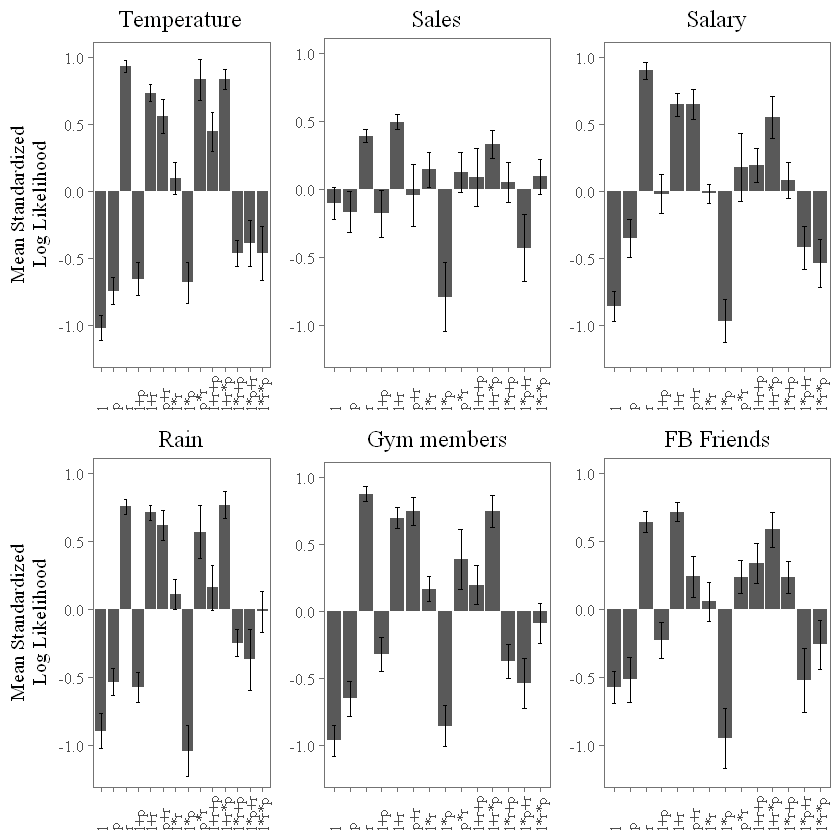

In [14]:
p1 <- plot_lmls(lmls_temperature, "Temperature", hide_x=TRUE)
p2 <- plot_lmls(lmls_rain, "Rain", hide_x=TRUE)
p3 <- plot_lmls(lmls_sales, "Sales", hide_x=TRUE, hide_y=TRUE)
p4 <- plot_lmls(lmls_gym, "Gym members", hide_y=TRUE, hide_x=TRUE)
p5 <- plot_lmls(lmls_salary, "Salary", hide_x=TRUE, hide_y=TRUE)
p6 <- plot_lmls(lmls_fb, "FB Friends", hide_y=TRUE, hide_x=TRUE)

#svg("Images/part_2/kernels_posterior_lmls.svg", width=8, height=4)
multiplot(p1, p2, p3, p4, p5, p6, cols=3)
#dev.off()